In [1]:
# import os
# import tensorflow as tf

# os.environ["KMP_BLOCKTIME"] = "1"
# os.environ["KMP_SETTINGS"] = "1"
# os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
# os.environ["OMP_NUM_THREADS"]= "32"
# tf.config.threading.set_intra_op_parallelism_threads(32)
# tf.config.threading.set_inter_op_parallelism_threads(2)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence , get_file
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler ,EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil


import os
import json
import sys

import datetime
import os
import time

from itertools import islice

import segmentation_models as sm
sm.set_framework('tf.keras')



out_train_data_dir = '/glade/scratch/hgamarro/Deep_learning/HG_space/data/processed/Vegas_v1/train'
out_val_data_dir = '/glade/scratch/hgamarro/Deep_learning/HG_space/data/processed/Vegas_v1/val'

Segmentation Models: using `tf.keras` framework.


In [4]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))    

    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y
        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path).astype('float32')
        return X, y    

In [5]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================

all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))}
val_partition = [item for item in all_val_files if "image_file" in item]

In [6]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

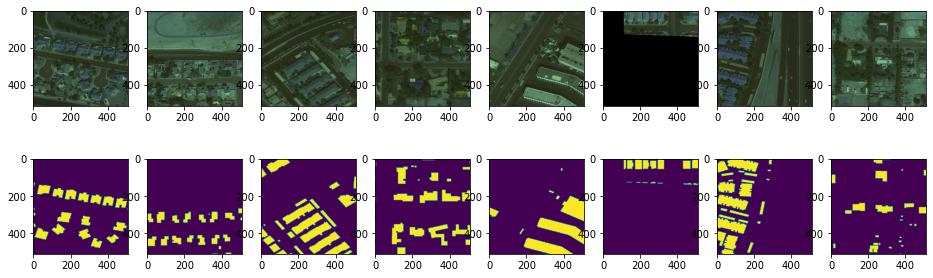

In [7]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = train_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [8]:
np.histogram(train_generator[22][0][a+5,:,:,:])

(array([  8346, 198491, 331472, 149194,  74844,  17011,   4506,   1609,
           751,    208]),
 array([0.        , 0.08784313, 0.17568627, 0.26352942, 0.35137254,
        0.4392157 , 0.52705884, 0.61490196, 0.7027451 , 0.79058826,
        0.8784314 ], dtype=float32))

In [9]:
print(np.histogram(train_generator[14][1][a+5,:,:,:]))

print(train_generator[14][1][a+5,:,:,:].dtype)

(array([238371,      0,      0,      0,      0,      0,      0,      0,
            0,  23773]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
float32


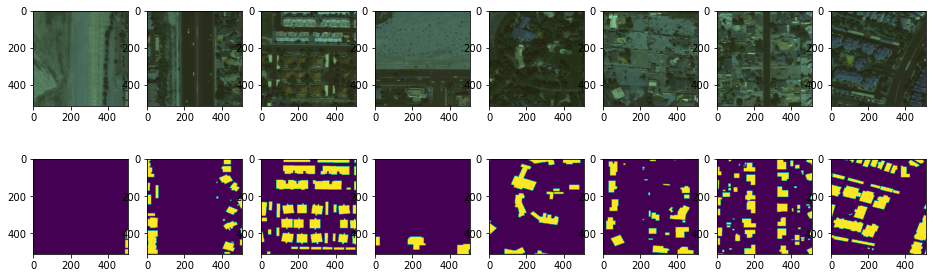

In [10]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = val_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = val_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [12]:
np.histogram(val_generator[5][0][a+5,:,:,:])

(array([ 26593, 355232, 270213,  87924,  33531,   9387,   1897,   1114,
           374,    167]),
 array([0.        , 0.08784313, 0.17568627, 0.26352942, 0.35137254,
        0.4392157 , 0.52705884, 0.61490196, 0.7027451 , 0.79058826,
        0.8784314 ], dtype=float32))

In [13]:
print(np.histogram(val_generator[5][1][a+5,:,:,:]))

print(val_generator[5][1][a+5,:,:,:].dtype)

(array([199334,      0,      0,      0,      0,      0,      0,      0,
            0,  62810]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
float32


In [15]:
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 15

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(classes=n_classes,input_shape=(512, 512, 3), activation=activation)

58892288/58889256 [==============================] - 1s 0us/step


In [17]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_2.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]



In [ ]:
from datetime import datetime
start = datetime.now()
 

history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_generator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    use_multiprocessing=True
)


end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Epoch 1/15
 1/35 [..............................] - ETA: 42:12 - loss: 0.8963 - iou_score: 0.1534 - f1-score: 0.2660

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/glade/u/home/hgamarro/miniconda3/envs/cartopy/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/glade/u/home/hgamarro/mi

In [33]:
model.save("../random/Working_UNET_v1.h5")

In [38]:
def plot_history(history):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss'] 
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

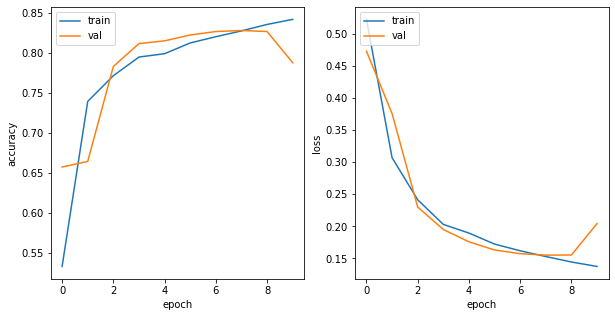

In [39]:
plot_history(model.history)

In [112]:
unet_history.history

{'loss': [0.3397311270236969,
  0.2453213632106781,
  0.20104505121707916,
  0.17998071014881134,
  0.16745956242084503],
 'accuracy': [0.8691030740737915,
  0.9017932415008545,
  0.9192923903465271,
  0.9277315735816956,
  0.9327933192253113],
 'val_loss': [0.5726802349090576,
  0.7990082502365112,
  0.8686065077781677,
  0.8145583271980286,
  1.2351468801498413],
 'val_accuracy': [0.7974129915237427,
  0.7995733618736267,
  0.7995733618736267,
  0.7995733618736267,
  0.7995580434799194]}

In [21]:
val_check =  model.predict(val_generator[1][0])

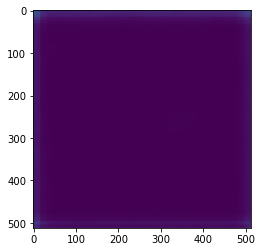

In [28]:
plt.imshow(val_check[12,:,:,0])


In [ ]:
val_generator[1][0][a + 5 , :,:,:]

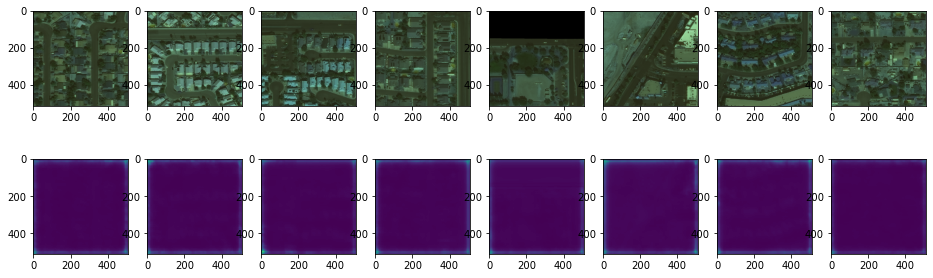

In [143]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = val_generator[1][0][a + 5 , :,:,:]

    # Load masks
    mask = val_check[a+5,:,:,:]
    
    
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)